### Noise Injection with the Laplace Mechanism

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io

This notebook explores one disclosure avoidance technique that injects Laplacian-distributed noise to tabulated PUMS data. First, let's download the PUMS data and read it into a pandas dataframe.

In [2]:
r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_ppa.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract('psam_p42.csv')
pa = pd.read_csv("psam_p42.csv")

For column codes see:
https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.pdf?

In [44]:
#Filtering geographic location, race, educational attainment, total income in past 12 months and age for all 18+ PA persons
new_pa = pa.query("AGEP>=18").filter(items=['PUMA','RAC1P','SCHL','WAGP','PINCP','AGEP'])
new_pa.head()

,PUMA,RAC1P,SCHL,WAGP,PINCP,AGEP
0,1300,1,16.0,0.0,7300.0,83
1,1300,1,21.0,0.0,11000.0,69
2,3401,1,22.0,0.0,75200.0,68
3,3401,1,21.0,0.0,36400.0,67
4,4002,1,19.0,0.0,2600.0,47


In [4]:
#make individualtables for persons of each broad (RAC1P) racial catagory. 

In [47]:
#create a table showing total count of educational attaninment of adults in PA by race. 
pivot_pa = pd.pivot_table(new_pa,
                              index='RAC1P',
                              columns='SCHL',
                              values='PINCP',
                              aggfunc=np.size,
                              margins=True)

pivot_pa.columns = ['No schooling','preschool','K','Grade 1','Grade 2','Grade 3','Grade 4','Grade 5','Grade 6','Grade 7','Grade 8'
                        ,'Grade 9','Grade 10','Grade 11','Grade 12-no diploma','HS diploma','GED','some college','1+ year college','Associate',
                        'Bachelor','Master','Professional','Doctorate','ALL']
pivot_pa.head(10)


,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3749.0,54.0,48.0,53.0,73.0,230.0,192.0,301.0,760.0,880.0,...,155828.0,17058.0,28869.0,52859.0,37029.0,76093.0,33779.0,7413.0,5328.0,456843.0
2,633.0,10.0,12.0,9.0,20.0,39.0,27.0,58.0,116.0,118.0,...,10704.0,2521.0,2696.0,6011.0,2318.0,3326.0,1607.0,271.0,234.0,35469.0
3,10.0,1.0,1.0,NaN,1.0,2.0,NaN,1.0,16.0,4.0,...,144.0,36.0,40.0,75.0,33.0,68.0,37.0,4.0,6.0,543.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,2.0,1.0,2.0,NaN,NaN,2.0,1.0,NaN,1.0,10.0
5,10.0,NaN,NaN,2.0,4.0,2.0,4.0,NaN,3.0,5.0,...,69.0,17.0,19.0,36.0,19.0,22.0,3.0,5.0,1.0,268.0
6,571.0,1.0,4.0,9.0,21.0,32.0,35.0,65.0,116.0,53.0,...,1847.0,163.0,583.0,1363.0,515.0,2982.0,1834.0,666.0,695.0,12446.0
7,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,10.0,10.0,15.0,6.0,16.0,12.0,1.0,2.0,122.0
8,225.0,2.0,2.0,12.0,14.0,45.0,34.0,53.0,129.0,60.0,...,1397.0,329.0,329.0,588.0,267.0,356.0,117.0,33.0,25.0,5044.0
9,77.0,4.0,1.0,3.0,4.0,9.0,11.0,13.0,34.0,21.0,...,1415.0,337.0,531.0,1135.0,456.0,877.0,348.0,107.0,67.0,6079.0


In [20]:
asn_df=pivot_pa[:1]
asn_df.head()
asn_df.shape

(1, 24)

In [16]:
asn_pa = pa.query('AGEP>=18 and RACASN==1 and FRACP==1')
asn_pa.groupby('RAC2P').count()
# a 2D table, row = educational attainment, col = race by RAC2P (asian ethnicity)
asn_pa_ed = asn_pa.groupby(['RAC2P','SCHL']).size().unstack()
asn_pa_ed.fillna(0)
all_pa_ed = asn_pa.groupby('SCHL').size()
print(all_pa_ed)
all_pa_ed.shape

SCHL
1.0       5
9.0       1
12.0      2
13.0      2
14.0      3
15.0      4
16.0     55
17.0      1
18.0     98
19.0    137
20.0      2
21.0     22
22.0      9
23.0      3
24.0      2
dtype: int64


(15,)

**The Laplace Mechanism**
The input is mu - a number or a numpy array, along with the privacy budget epsilon and sensitivity of the query that produced mu.

In [7]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

### Quality Metrics

While the trade-off between statistical accuracy and privacy loss is at the heart of differential privacy, there are many metrics for assessing the quality of a published dataset. One approach is to calculate the L1 error between the true data (i.e. without disclosure limitation) and the privatized data.

**The L1 Norm** In this simple scenario involving the Laplace Mechanism, the L1 error is a natural metric. This is a coarse measure: a disclosure limited product with a high L1 compared to the same product without disclosure limitation may still be very accurate for its intended use. 

In [8]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n

### Trade-off Between Privacy Loss and Accuracy

When submitting to the DRB, the practitioner prepares a set of graphs that show the trade-off between privacy loss (ϵ) and accuracy. DRB officials then picks a value of ϵ that allows for sufficient accuracy. Officials most often estimate with epsilon values between 1 and 9.

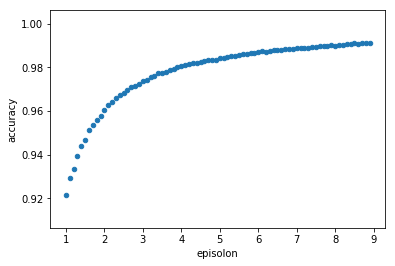

In [24]:
orig_arr = pd.DataFrame(asn_df)
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,9.0,.1)
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()

### Postprocessing

Postprocessing the output of a DP mechanism does not degrade privacy. In this case, we want to round any negative counts to zero.

In [10]:
noisy_counts = laplace_mech(orig_arr, 1)
noisy_counts

RAC2P,38,42,43,44,45,47,48,49,51,54,55,56,57,58,59,68
SCHL,,,,,,,,,,,,,,,,
1.0,NaN,NaN,2.222130,NaN,NaN,NaN,NaN,NaN,NaN,1.306750,NaN,NaN,-1.519399,NaN,0.601420,NaN
9.0,NaN,NaN,0.121075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12.0,NaN,NaN,0.497377,NaN,1.557855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.0,NaN,NaN,NaN,NaN,0.287536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.617819,NaN,NaN,NaN
14.0,0.762675,-0.073164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.901438
15.0,NaN,NaN,2.089465,NaN,2.373226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.703644,NaN,NaN,NaN
16.0,12.284397,NaN,26.332680,NaN,3.166117,NaN,NaN,4.051651,NaN,2.450209,NaN,NaN,1.786818,1.089604,1.147270,6.846671
17.0,NaN,NaN,-0.114453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18.0,39.477605,NaN,16.651690,1.042165,1.107394,3.192686,-1.964318,12.233574,NaN,4.041769,1.058436,1.421659,1.737863,NaN,5.760578,3.850608


In [11]:
for i in range(1, 24):
    if noisy_counts[i].item() < 0:
        noisy_counts[i] = 0

KeyError: 1

In [ ]:
noisy_counts